<a href="https://colab.research.google.com/github/saguileran/MD-SCPI/blob/main/NoteBooks/PyEMMA_AS4_mut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyEMMA

In [1]:
%%capture
!pip install pyemma
#!pip install nglview

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pyemma.coordinates as coor
import pyemma
import numpy as np
import matplotlib.pyplot as plt
#import nglview
from matplotlib.colors import to_hex
from itertools import product
import matplotlib as mpl
import random
from google.colab import output
import pandas as pd

In [4]:
def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
  with pyemma.util.contexts.settings(show_progress_bars=False):
      nval = int(len(data) * validation_fraction)
      scores = np.zeros(number_of_splits)
      for n in range(number_of_splits):
          ival = np.random.choice(len(data), size=nval, replace=False)
          vamp = pyemma.coordinates.vamp(
              [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
          scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
  return scores

In [5]:
ligand = 'AS4_mut'
root = '/content/drive/MyDrive/MolecularDynamics_2023/USP/MC/{}/7000K/'.format(ligand)
pdb = '/content/drive/MyDrive/MolecularDynamics_2023/USP/MC/{}_H.pdb'.format(ligand[:3])
files = [root+str(i)+".nc" for i in range(0,50)]
feat = coor.featurizer(pdb)
# just use all xyz-coordinates
feat.add_all()
data = coor.load(files, features=feat)
labels = ['coordinates']  

Obtaining file info:   0%|          | 0/50 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/50 [00:00<?, ?it/s]

In [6]:
lagtime = 10
tica = pyemma.coordinates.tica(data, lag=lagtime, dim=10)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)

<ipython-input-6-8ae3d7b3dd64>:2: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from <ipython-input-6-8ae3d7b3dd64> line 2. Use deeptime.decomposition.TICA instead.
  tica = pyemma.coordinates.tica(data, lag=lagtime, dim=10)


calculate covariances:   0%|          | 0/50 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/50 [00:00<?, ?it/s]

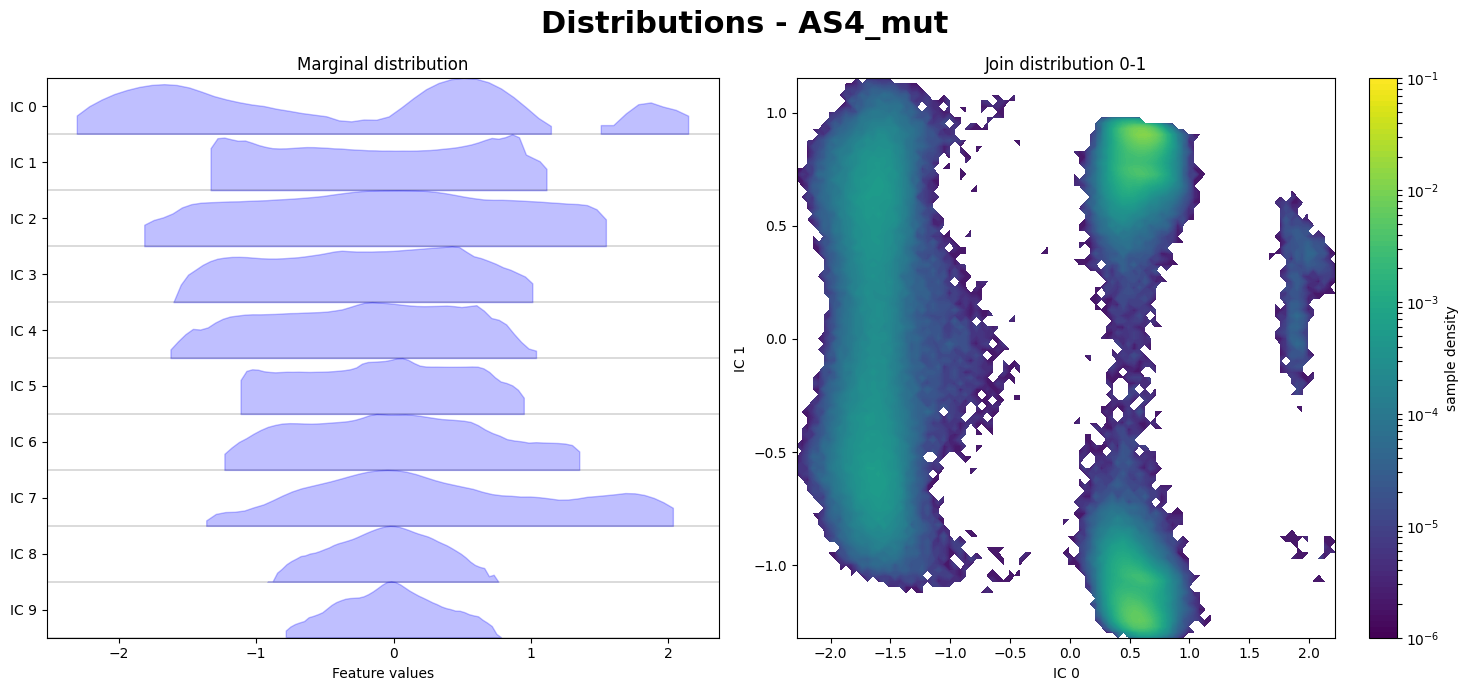

In [7]:
#@title marginal and joint distributions
c1, c2 = 0, 1  # choose ICs

plt.close()
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
pyemma.plots.plot_feature_histograms( tica_concatenated,
                                      ax=axes[0],
                                      feature_labels=["IC {}".format(i) for i in range(tica_concatenated.shape[1])],
                                      ylog=True )
pyemma.plots.plot_density(*tica_concatenated[:, [c1,c2]].T, ax=axes[1], logscale=True)

axes[0].set_title('Marginal distribution')
axes[1].set_xlabel('IC {}'.format(c1));  axes[1].set_ylabel('IC {}'.format(c2))
axes[1].set_title('Join distribution {}-{}'.format(c1,c2))
plt.suptitle('Distributions - '+ligand, fontweight='bold', fontsize='22')
fig.tight_layout()

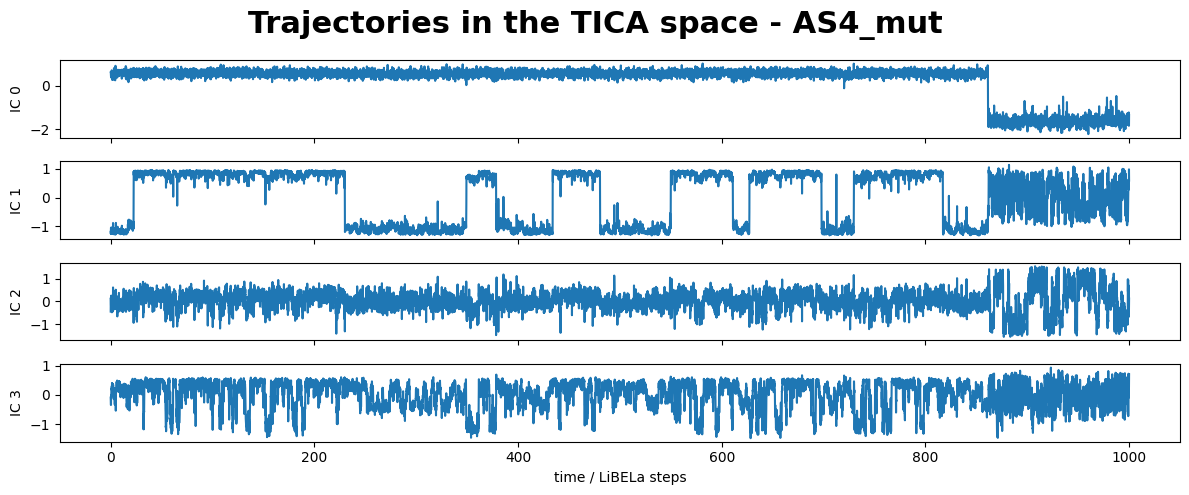

In [8]:
#@title TICA space
plt.close()
fig, axes = plt.subplots(4, 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_output[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i))
axes[-1].set_xlabel('time / LiBELa steps')
plt.suptitle('Trajectories in the TICA space - '+ligand, fontweight='bold', fontsize='22')
fig.tight_layout()

In [9]:
%%capture

# fig, (ax, ax_1) = plt.subplots(1,2,figsize=(14,7))

# n_clustercenters = [5, 10, 30, 75, 200, 450, 900]
# scores = np.zeros((len(n_clustercenters), 5))
# for n, k in enumerate(n_clustercenters):
#     for m in range(5):
#         #with pyemma.util.contexts.settings(show_progress_bars=False):
#             _cl = pyemma.coordinates.cluster_kmeans(
#                 tica_output, k=k, max_iter=50, stride=50)
#             _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, 5)
#             scores[n, m] = _msm.score_cv(
#                 _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

# lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
# ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
# ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
# ax.semilogx()
# ax.set_xlabel('number of cluster centers')
# ax.set_ylabel('VAMP-2 score')

# # ---------------  dimensions ---------------
# lags = [1, 2, 5, 10, 20, 50, 100]
# dims = [i + 1 for i in range(10)]

# for i, lag in enumerate(lags):
#     scores_ = np.array([score_cv(data, dim, lag)
#                         for dim in dims])
#     scores = np.mean(scores_, axis=1)
#     errors = np.std(scores_, axis=1, ddof=1)
#     color = 'C{}'.format(i)
#     ax_1.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
#     ax_1.plot(dims, scores, '--o', color=color, label='lag={:.1f}steps'.format(lag * 1.0))
# ax_1.legend()
# ax_1.set_xlabel('number of dimensions')
# ax_1.set_ylabel('VAMP2 score')

# fig.tight_layout()

<ipython-input-10-d2b04a791fbb>:3: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from <ipython-input-10-d2b04a791fbb> line 3. Use deeptime.clustering.KMeans instead.
  cluster = pyemma.coordinates.cluster_kmeans(tica_output, k=600, max_iter=500, stride=1)#, fixed_seed=1) #


initialize kmeans++ centers:   0%|          | 0/600 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/500 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|          | 0/50 [00:00<?, ?it/s]

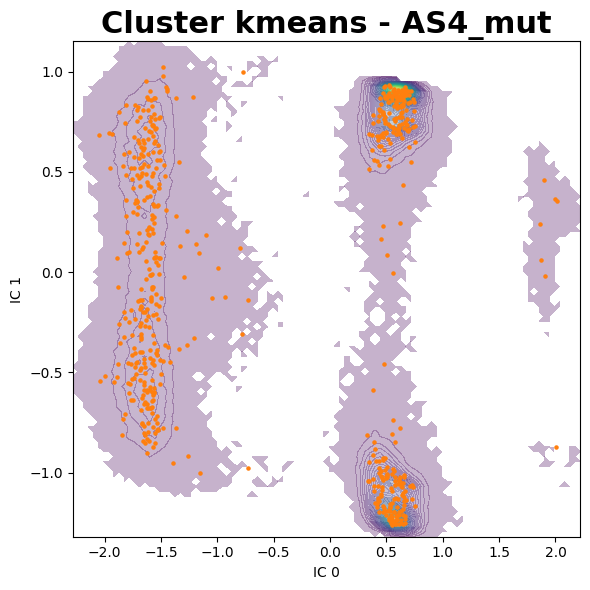

In [10]:
#@title Clusters
plt.close()
cluster = pyemma.coordinates.cluster_kmeans(tica_output, k=600, max_iter=500, stride=1)#, fixed_seed=1) #  
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

fig, ax = plt.subplots(figsize=(6, 6))
pyemma.plots.plot_density(*tica_concatenated[:, [c1,c2]].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster.clustercenters[:, [c1,c2]].T, s=5, c='C1')
ax.set_xlabel('IC '+str(c1)); ax.set_ylabel('IC '+str(c2))
plt.title('Cluster kmeans - '+ligand, fontsize='22', fontweight='bold')

fig.tight_layout()

In [10]:
# %%time
# its = pyemma.msm.its(cluster.dtrajs, lags=20, nits=10, errors='bayes')
# pyemma.plots.plot_implied_timescales(its, units='LiBELa steps', dt=1.0);

In [11]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lagtime, dt_traj='1.0 ns')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

pyemma.msm.estimators.bayesian_msm.BayesianMSM[6]: Sampling MSMs:   0%|          | 0/100 [00:00<?, ?it/s]

fraction of states used = 0.99
fraction of counts used = 1.00


estimating BayesianMSM:   0%|          | 0/9 [00:00<?, ?it/s]

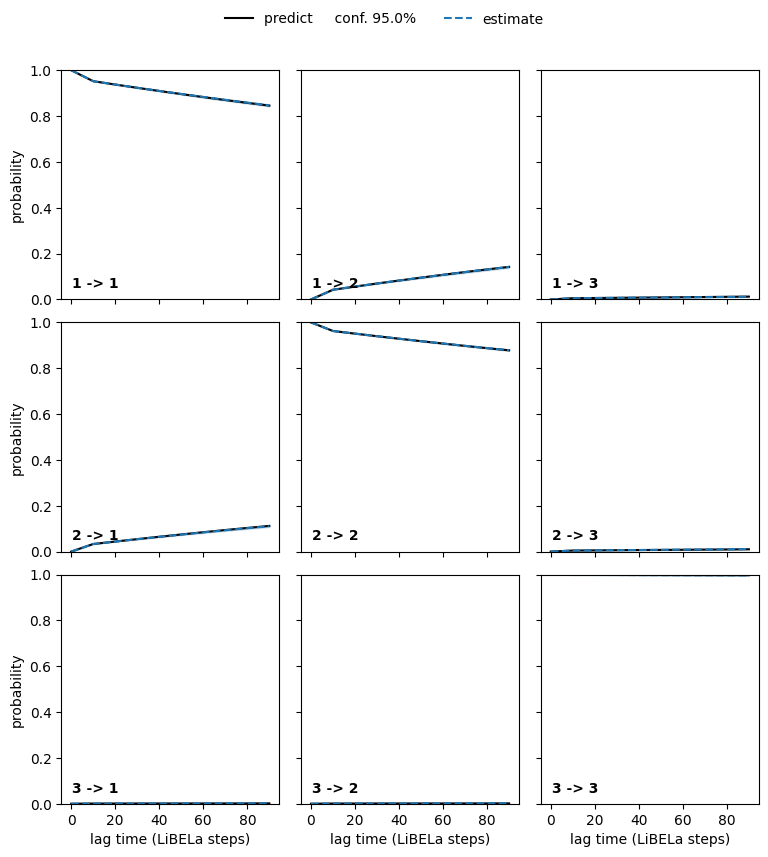

In [12]:
#@title Chapman-Kolmogorov test
nstates = 3
plt.close()
cktest = msm.cktest(nstates, mlags=10)
pyemma.plots.plot_cktest(cktest, dt=1.0, units='LiBELa steps');

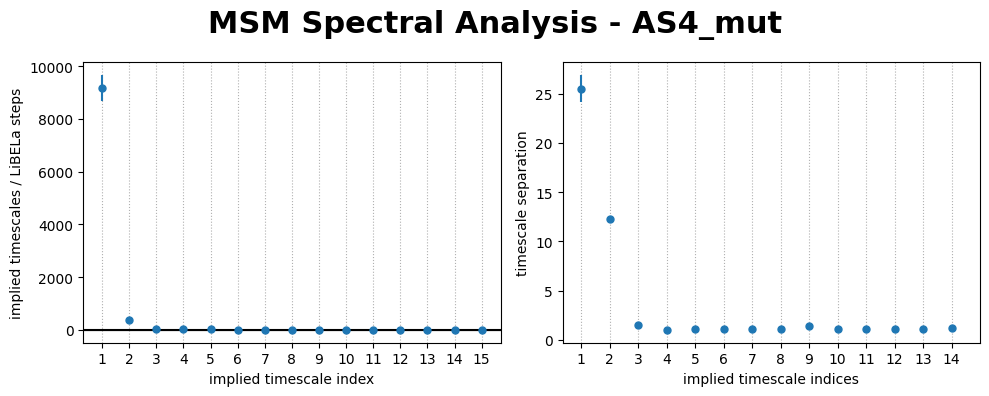

In [13]:
#@title MSM Spectral Analysis
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)


nits = 15
plt.close()

timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std  = msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar( range(1, nits + 1),
                  timescales_mean,
                  yerr=timescales_std,
                  fmt='.', markersize=10 )
axes[1].errorbar( range(1, nits),
                  timescales_mean[:-1] / timescales_mean[1:],
                  yerr=its_separation_err(timescales_mean, timescales_std),
                  fmt='.',
                  markersize=10,
                  color='C0' )

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')

axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / LiBELa steps')
axes[1].set_xticks(range(1, nits))
#axes[1].set_xticklabels(["{:d}/{:d}".format(k, k + 1) for k in range(1, nits + 2)], rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
plt.suptitle('MSM Spectral Analysis - '+ligand, fontweight='bold', fontsize='22')
fig.tight_layout()

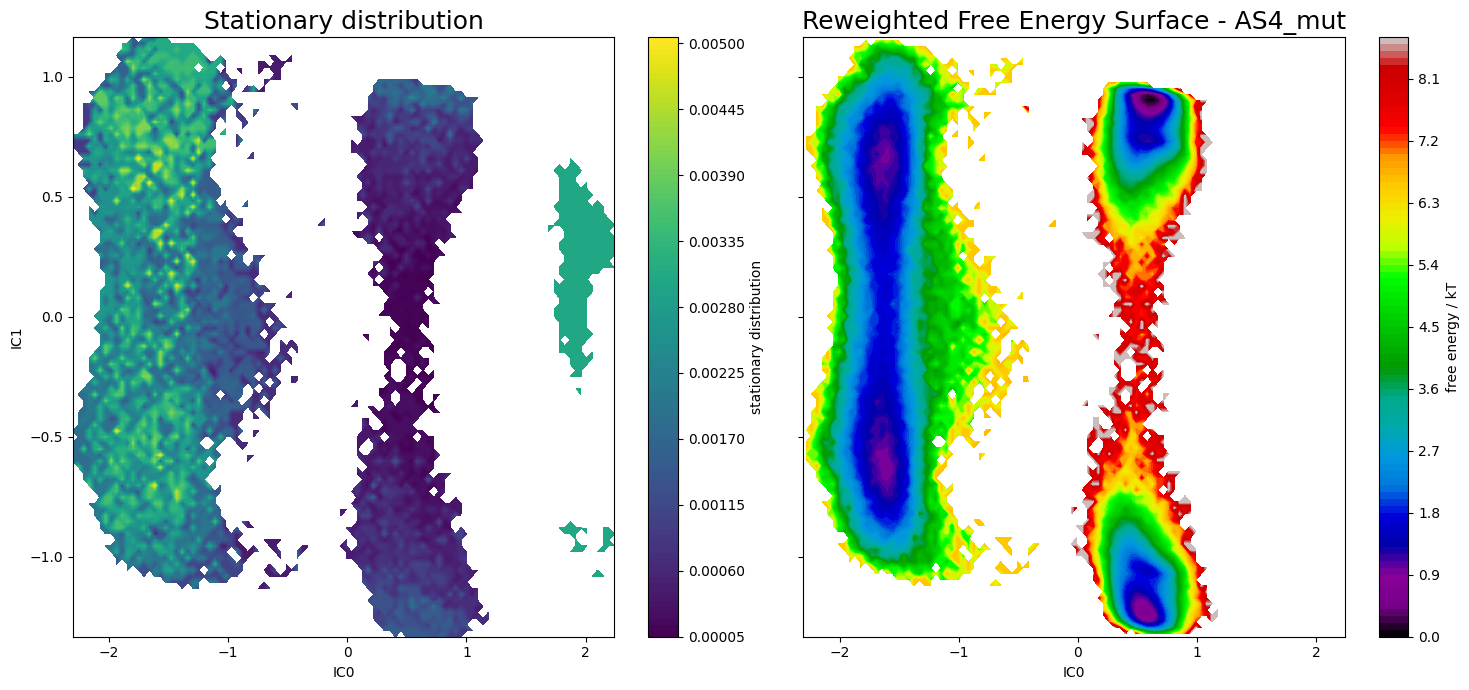

In [14]:
#@title Stationary Distribution and Free Energy 
plt.close()
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)
pyemma.plots.plot_contour( *tica_concatenated[:, [c1,c2]].T,
                            msm.pi[np.concatenate(msm.dtrajs_active)],
                            ax=axes[0],
                            mask=True,
                            cbar_label='stationary distribution' )
pyemma.plots.plot_free_energy( *tica_concatenated[:, [c1,c2]].T,
                               weights=np.concatenate(msm.trajectory_weights()),
                               ax=axes[1],
                               legacy=False )

for ax in axes.flat: ax.set_xlabel('IC'+str(c1))

axes[0].set_ylabel('IC'+str(c2))
axes[0].set_title('Stationary distribution', fontsize='18')
axes[1].set_title('Reweighted Free Energy Surface - '+ligand, fontsize='18')
fig.tight_layout()

The first eigenvector is one: True (min=0.99999999999856, max=1.000000000000488)


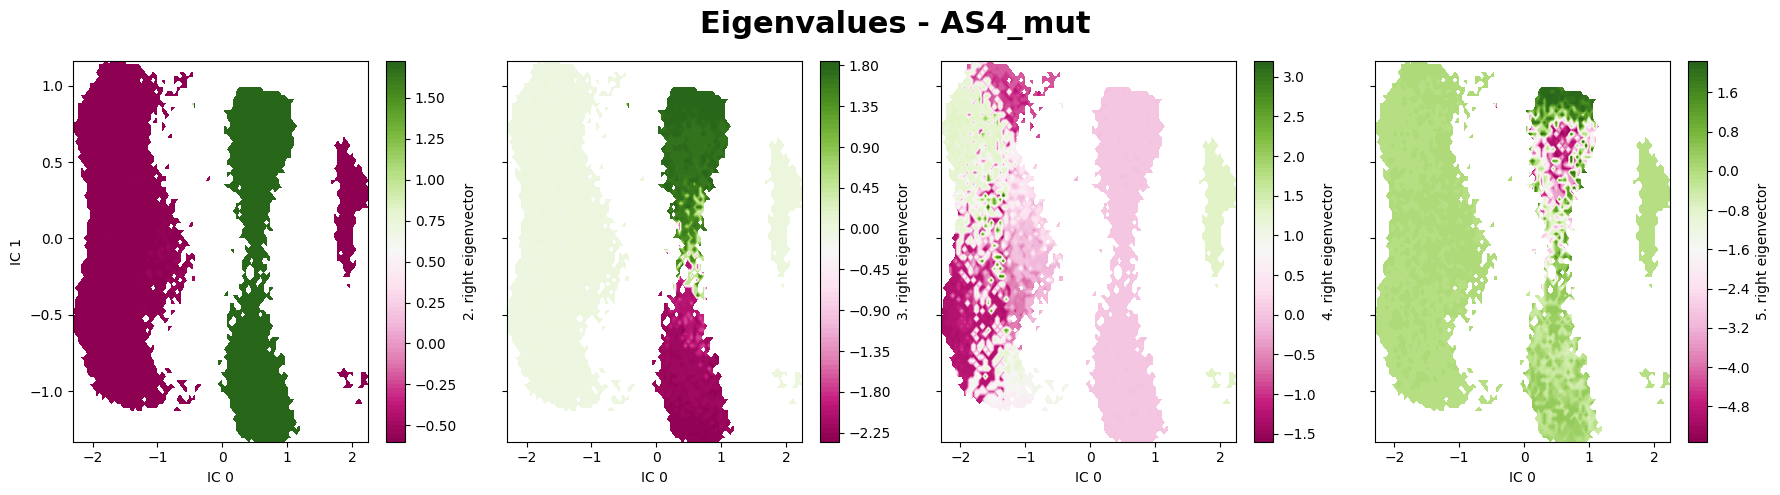

In [15]:
#@title Eigenvectors
plt.close()
eigvec = msm.eigenvectors_right()
print('The first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(*tica_concatenated[:, [c1,c2]].T,
                              eigvec[np.concatenate(msm.dtrajs_active), i + 1],
                              ax=ax,
                              cmap='PiYG',
                              cbar_label='{}. right eigenvector'.format(i + 2),
                              mask=True)
    ax.set_xlabel('IC '+str(c1))

axes[0].set_ylabel('IC '+str(c2))
plt.suptitle('Eigenvalues - '+ligand, fontweight='bold', fontsize='22')
fig.tight_layout()

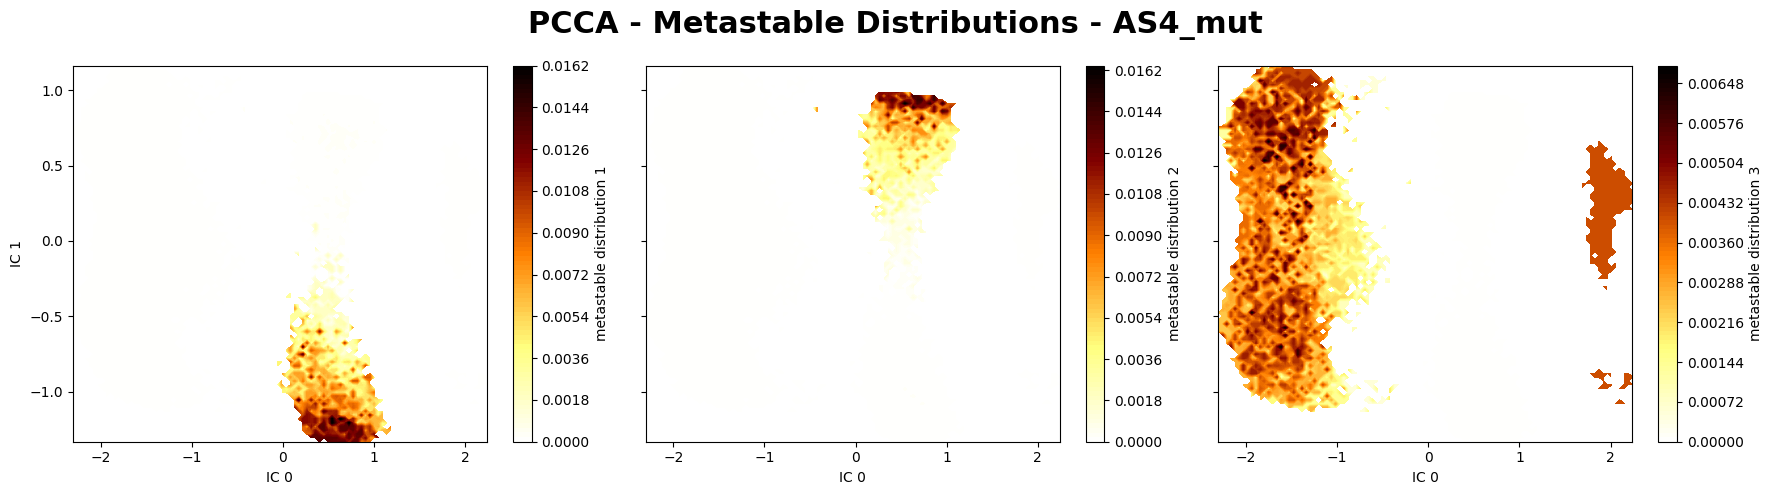

In [16]:
#@title PCCA - Metastable Distributions

plt.close()
msm.pcca(nstates)

fig, axes = plt.subplots(1, nstates, figsize=(18, 5), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(*tica_concatenated[:, :2].T,
                              msm.metastable_distributions[i][np.concatenate(msm.dtrajs_active)],
                              ax=ax,
                              cmap='afmhot_r',
                              mask=True,
                              cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC '+str(c1))
axes[0].set_ylabel('IC '+str(c2))
plt.suptitle('PCCA - Metastable Distributions - '+ligand, fontweight='bold', fontsize='22')
fig.tight_layout()

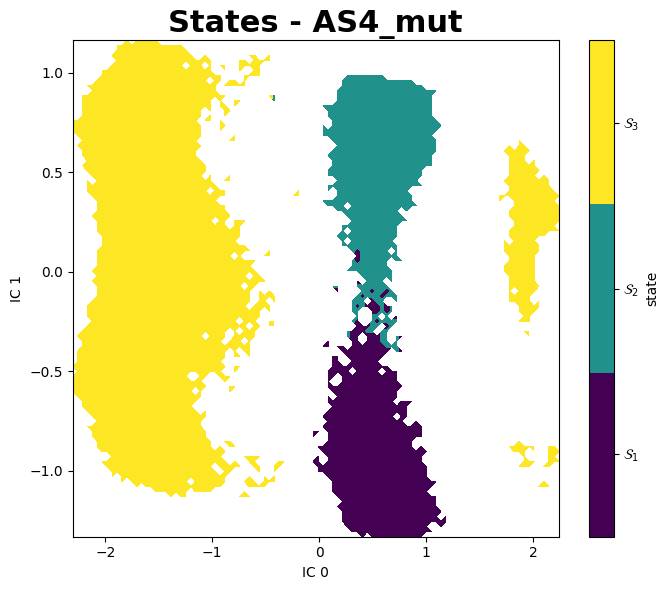

In [17]:
#@title States
plt.close()
metastable_traj = msm.metastable_assignments[np.concatenate(msm.dtrajs_active)]

fig, ax = plt.subplots(figsize=(7, 6))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC '+str(c1));  ax.set_ylabel('IC '+str(c2))
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1) for i in range(nstates)])
plt.title('States - '+ligand, fontweight='bold', fontsize='22')
fig.tight_layout()

In [18]:
#@title PDBs Example
NoSamples = 20
pcca_samples = msm.sample_by_distributions(msm.metastable_distributions, NoSamples)
source = pyemma.coordinates.source(files, features=feat)
pyemma.coordinates.save_trajs(source, pcca_samples,
                              outfiles=['./pcca_{}-{}_{}samples.pdb'.format(ligand, n+1, NoSamples) for n in range(msm.n_metastable)])

Obtaining file info:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/scipy/io/_netcdf.py:305: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  warnings.warn((


['./pcca_AS4_mut-1_20samples.pdb',
 './pcca_AS4_mut-2_20samples.pdb',
 './pcca_AS4_mut-3_20samples.pdb']

In [ ]:
# #@title Examples Visualization
# def visualize_metastable(samples, cmap, selection='not element H'):
#     """ visualize metastable states
#     Parameters
#     ----------
#     samples: list of mdtraj.Trajectory objects
#         each element contains all samples for one metastable state.
#     cmap: matplotlib.colors.ListedColormap
#         color map used to visualize metastable states before.
#     selection: str
#         which part of the molecule to selection for visualization. For details have a look here:
#         http://mdtraj.org/latest/examples/atom-selection.html#Atom-Selection-Language
#     """

#     widget = nglview.NGLWidget()
#     widget.clear_representations()
#     ref = samples[0]
#     for i, s in enumerate(samples):
#         s = s.superpose(ref, atom_indices=s.top.select('resid 0'))
#         s = s.atom_slice(s.top.select(selection))
#         comp = widget.add_trajectory(s)
#         comp.add_licorice()

#     # this has to be done in a separate loop for whatever reason...
#     x = np.linspace(0, 1, num=len(samples))
#     for i, x_ in enumerate(x):
#         c = to_hex(cmap(x_))
#         widget.update_licorice(color=c, component=i, repr_index=i)
#         widget.remove_cartoon(component=i)
#     return widget

# output.enable_custom_widget_manager()
# my_samples = [pyemma.coordinates.save_traj(files, idist, outfile=None, top=pdb)
#               for idist in msm.sample_by_distributions(msm.metastable_distributions, 50)]

# cmap = mpl.colormaps['viridis']#('viridis', nstates)
# visualize_metastable(my_samples, cmap)

In [ ]:
#output.disable_custom_widget_manager()

In [19]:
#@title π and G/kT 
print('state\tπ\t\tG/kT')
for i, s in enumerate(msm.metastable_sets):
    p = msm.pi[s].sum()
    print('{}\t{:f}\t{:f}'.format(i + 1, p, -np.log(p)))

state	π		G/kT
1	0.110412	2.203541
2	0.142507	1.948367
3	0.747082	0.291581


In [20]:
#@title MFPT
mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(msm.metastable_sets[i], msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / LiBELa steps:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT / LiBELa steps:


,1,2,3
1,0.00,2491.70,12450.96
2,3296.10,0.00,12442.07
3,38690.24,37897.58,0.00


In [21]:
A, B = msm.metastable_sets[0], np.concatenate(msm.metastable_sets[1:])
print('MFPT 1 -> other: ({:6.1f} ± {:5.1f}) LiBELa steps'.format(
    msm.sample_mean('mfpt', A, B), msm.sample_std('mfpt', A, B)))
print('MFPT other -> 1: ({:.1f} ± {:5.1f}) LiBELa steps'.format(
    msm.sample_mean('mfpt', B, A), msm.sample_std('mfpt', B, A)))

MFPT 1 -> other: ( 621.3 ±  12.4) LiBELa steps
MFPT other -> 1: (30290.6 ± 2130.8) LiBELa steps


In [22]:
#@title Coarse Grain Between States
start, final = 0, 2
A, B = msm.metastable_sets[start], msm.metastable_sets[final]
flux = pyemma.msm.tpt(msm, A, B)

cg, cgflux = flux.coarse_grain(msm.metastable_sets)

In [23]:
hmm = msm.coarse_grain(nstates)
hmm.stationary_distribution

RuntimeError: ignored

In [ ]:
pd.DataFrame(hmm.transition_matrix)

In [ ]:
pos=np.array([[-1, 0], [0, 1], [1, 0]])
pyemma.plots.plot_markov_model(hmm, pos=pos, arrow_label_format='%.1E', state_colors=['indigo','teal','yellow'], state_labels=['1','2','3'], 
                              fontweight='bold', size='11', arrow_curvature=1.5)
plt.title('HMM Network Plot - Transition Probabilities - AS4_mut', fontweight='bold', fontsize='18')
plt.gca().set_frame_on(False)

In [ ]:
# # @title Transition Path Theory
# fig, ax = plt.subplots(figsize=(7, 6))

# pyemma.plots.plot_contour(*tica_concatenated[:, [c1,c2]].T,
#                           flux.committor[dtrajs_concatenated],
#                           cmap='brg',
#                           ax=ax,
#                           mask=True,
#                           cbar_label=r'committor $\mathcal{S}_%d \to \mathcal{S}_%d$' % (
#                               start + 1, final + 1))
# plt.title('Transition Path Theory - '+ligand, fontweight='bold', fontsize='22')
# fig.tight_layout()

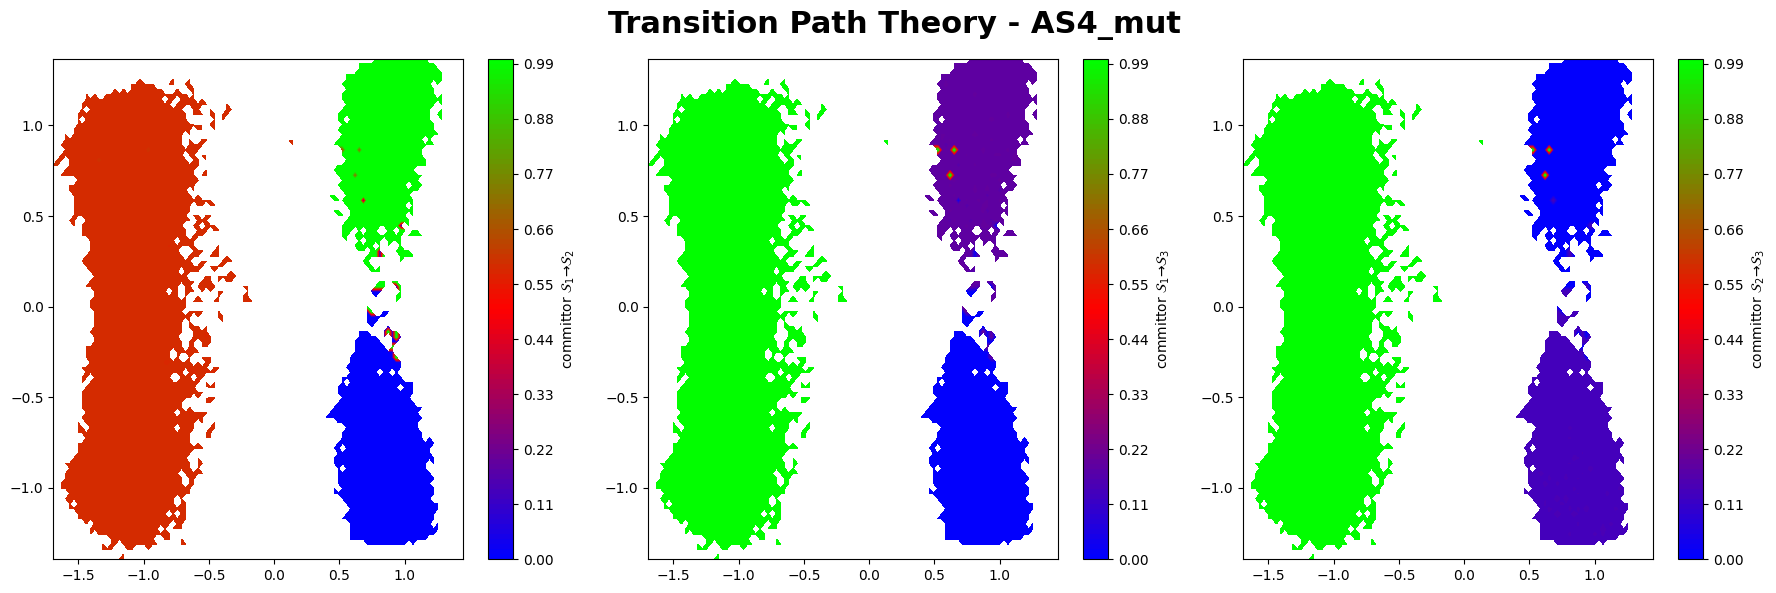

In [ ]:
#@title Transition Path Theory
fig, axes = plt.subplots(1,3, figsize=(18, 6))

# --------- 1->2, 1->3 ----------
for i in range(1,nstates):
  flux = pyemma.msm.tpt(msm, msm.metastable_sets[0], msm.metastable_sets[i])
  cg, cgflux = flux.coarse_grain(msm.metastable_sets)
  pyemma.plots.plot_contour(*tica_concatenated[:, [c1,c2]].T, flux.committor[dtrajs_concatenated], cmap='brg', ax=axes[i-1], mask=True,
                            cbar_label=r'committor $\mathcal{S}_%d \to \mathcal{S}_%d$' % (0 + 1, i + 1))
  
flux = pyemma.msm.tpt(msm, msm.metastable_sets[1], msm.metastable_sets[2])
cg, cgflux = flux.coarse_grain(msm.metastable_sets)
pyemma.plots.plot_contour(*tica_concatenated[:, [c1,c2]].T, flux.committor[dtrajs_concatenated], cmap='brg', ax=axes[2], mask=True,
                          cbar_label=r'committor $\mathcal{S}_%d \to \mathcal{S}_%d$' % (1 + 1, 2 + 1))

plt.suptitle('Transition Path Theory - '+ligand, fontweight='bold', fontsize='22')
fig.tight_layout()